# CareerVillage knowledge graph analysis with node embeddings

# 1. Introduction

## a.) What is a knowledge graph?

It is a network that represents multiple types of entities (nodes) and relations (edges) in the same graph. Each link of the network represents an (entity,relation,value) triplet. For example I give you some examples from the small knowledge graph below:

- Eiffel Tower **(entity)** is located in **(relation)** in Paris **(value)**
- Paris **(entity)** is an instance of **(relation)** city **(value)**
- Alice **(entity)** is an instance of **(relation)** person **(value)**

![Example knowledge graph](https://geomarketing.com/wp-content/uploads/2017/11/Amazon-Neptune-Knowledge-Graph.jpg)

The CareerVillage data set contains several different entities (persons, groups, schools, locations etc.). Thus one possible approach to analyse this data is to build a large knowledge graph representing as many relations as possible.

## b.) What are node embeddings?

Embeddings, especially word representations (e.g. Word2Vec), is a hot research topic nowadays. The basic idea behind node embedding algorithms (e.g. node2vec, Line, DeepWalk etc.) is that if you generate node sequences originating from a given vertex and feed them to Word2Vec (like sentences from a text) you can map the nodes of the network into a low dimensional vector space. Usually these methods are optimized for the criteria to preserve the global/local role of each vertex in the graph.

![Example node embeding](https://www.sentiance.com/wp-content/uploads/2018/01/deepwalk1-2.png)

## c.) My work

In this work I use the [node2vec](https://cs.stanford.edu/people/jure/pubs/node2vec-kdd16.pdf) algorithm to generate low dimensional representation for CareerVillage users based on the knowledge graph that I extracted from the data. My ultimate goal is to discover interesting user groups / clusters (e.g. popular professionals, satisfied students etc.) using only the available network structure.

> # 2. Load data

In [ ]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from collections import Counter

In [ ]:
files = os.listdir("../input")
files

In [ ]:
data_parts = {}
for file_name in files:
    file_id = file_name.split(".")[0]
    data_parts[file_id] = pd.read_csv("../input/" + file_name)
    print(file_id)
    print(data_parts[file_id].shape)

# 3. Build knowledge graph from CareerVillage data

In [ ]:
def add_nodes(G, df, col, type_name):
    """Add entities to G from the 'col' column of the 'df' DataFrame. The new nodes are annotated with 'type_name' label."""
    nodes = list(df[~df[col].isnull()][col].unique())
    G.add_nodes_from([(n,dict(type=type_name)) for n in nodes])
    print("Nodes (%s,%s) were added" % (col, type_name))
    
def add_links(G, df, col1, col2, type_name):
    """Add links to G from the 'df' DataFrame. The new edges are annotated with 'type_name' label."""
    df_tmp = df[(~df[col1].isnull()) & (~df[col2].isnull())]
    links = list(zip(df_tmp[col1],df_tmp[col2]))
    G.add_edges_from([(src, trg, dict(type=type_name)) for src, trg in links])
    print("Edges (%s->%s,%s) were added" % (col1, col2, type_name))

In [ ]:
G = nx.DiGraph()

## i.) Nodes

The vertices of the knowledge graph consists of the following entities:
- answers
- questions
- comments
- students
- professionals
- industries
- schools
- tags
- user groups
- group types

In [ ]:
add_nodes(G, data_parts["answers"], "answers_id", "answer")
add_nodes(G, data_parts["comments"], "comments_id", "comment")
add_nodes(G, data_parts["groups"], "groups_id", "group")
add_nodes(G, data_parts["groups"], "groups_group_type", "group_type")
add_nodes(G, data_parts["professionals"], "professionals_id", "professional")
add_nodes(G, data_parts["professionals"], "professionals_industry", "industry")
add_nodes(G, data_parts["questions"], "questions_id", "question")
add_nodes(G, data_parts["school_memberships"], "school_memberships_school_id", "school")
add_nodes(G, data_parts["students"], "students_id", "student")
add_nodes(G, data_parts["tags"], "tags_tag_id", "tag")

## ii.) Edges

In [ ]:
add_links(G, data_parts["answers"], "answers_id", "answers_question_id", "question")
add_links(G, data_parts["answers"], "answers_id", "answers_author_id", "author")
add_links(G, data_parts["comments"], "comments_id", "comments_parent_content_id", "parent_content")
add_links(G, data_parts["comments"], "comments_id", "comments_author_id", "author")
add_links(G, data_parts["group_memberships"], "group_memberships_user_id", "group_memberships_group_id", "member")
add_links(G, data_parts["groups"], "groups_id", "groups_group_type", "type")
add_links(G, data_parts["professionals"], "professionals_id", "professionals_industry", "type")
add_links(G, data_parts["questions"], "questions_id", "questions_author_id", "author")
add_links(G, data_parts["school_memberships"], "school_memberships_user_id", "school_memberships_school_id", "member")
add_links(G, data_parts["tag_questions"], "tag_questions_question_id", "tag_questions_tag_id", "tag")
add_links(G, data_parts["tag_users"], "tag_users_user_id", "tag_users_tag_id", "follow")

## iii.) Location information

Location information of users and professionals are preprocessed before I add it to the knowledge graph. I tried to extract **city / state / country** hierarchy from locations were it was provided. In this case I created different levels for locations: cities, states/regions and countries.

In [ ]:
students = data_parts["students"]
profs = data_parts["professionals"]
students = students[~students["students_location"].isnull()]
profs = profs[~profs["professionals_location"].isnull()]

In [ ]:
locs1 = list(students["students_location"])
locs2 = list(profs["professionals_location"])
locs = [loc.lower() for loc in locs1+locs2]
locs_unique = list(set(locs))

#### Most common locations:

In [ ]:
cnt = Counter(locs)
cnt.most_common()[:10]

#### Preprocess location information:

In [ ]:
new_edges = []
new_nodes = []
for loc in locs_unique:
    loc_hierarchy = loc.split(", ")
    loc_nodes = [] # due to city name duplicates in the world
    k = len(loc_hierarchy)
    for i in range(k):
        loc_nodes.append('_'.join(loc_hierarchy[i:]))
    new_nodes += loc_nodes
    loc_links = [(loc_nodes[i],loc_nodes[i+1], dict(type="location"))  for i in range(k-1)]
    new_edges += loc_links
new_nodes = list(set(new_nodes))
new_nodes = [(n, dict(type="location")) for n in new_nodes]

#### Add location nodes to the graph

- the 3 level of nodes are added
- connections between cities -> regions, regions -> contires are added

In [ ]:
G.add_nodes_from(new_nodes)
G.add_edges_from(new_edges)
print(len(new_edges), len(new_nodes))

#### Examples:

- Locations that are immediate in-neighbors of entity United Kingdom (e.g.: England, Scotland etc.).

In [ ]:
list(G.in_edges("united kingdom"))[:5]

- Locations that are in-neighbors of entity England

In [ ]:
list(G.in_edges("england_united kingdom"))[:5]

#### Link users to the first level of locations:

In [ ]:
students["students_location"] = students["students_location"].apply(lambda x: "_".join(x.lower().split(", ")))
profs["professionals_location"] = profs["professionals_location"].apply(lambda x: "_".join(x.lower().split(", ")))

In [ ]:
add_links(G, students, "students_id", "students_location", "location")
add_links(G, profs, "professionals_id", "professionals_location", "location")

## iv.) Clean and encode knowledge graph

In [ ]:
def encode_graph(G):
    """Encode the nodes of the network into integers"""
    nodes = [(n,d.get("type",None)) for n, d in G.nodes(data=True)]
    nodes_df = pd.DataFrame(nodes, columns=["id","type"]).reset_index()
    node2idx = dict(zip(nodes_df["id"],nodes_df["index"]))
    edges = [(node2idx[src], node2idx[trg], d.get("type",None)) for src, trg, d in G.edges(data=True)]
    edges_df = pd.DataFrame(edges, columns=["src","trg","type"])
    return nodes_df, edges_df

#### Remove isolated nodes

In [ ]:
print(G.number_of_nodes(), G.number_of_edges())
G.remove_nodes_from(list(nx.isolates(G)))
print(G.number_of_nodes(), G.number_of_edges())

#### Encode the nodes to have integer identifiers

In [ ]:
nodes_df, edges_df = encode_graph(G)
len(nodes_df), len(edges_df)

#### Node information summary

In [ ]:
print(nodes_df.head())
print(nodes_df["type"].value_counts())
nodes_df.to_csv("knowledge_graph_nodes.csv", index=False)

#### Edge information summary

In [ ]:
print(edges_df.head())
print(edges_df["type"].value_counts())
edges_df[["src","trg"]].to_csv("knowledge_graph_edges.csv", index=False, header=False, sep=" ")

# 4. Node2Vec

In [ ]:
edge_list = list(zip(edges_df["src"],edges_df["trg"]))
edge_list[:5]

In [ ]:
KG = nx.Graph(edge_list)
KG.number_of_nodes(), KG.number_of_edges()

#### NOTE: We will analyse only the greatest (weakly) connected component of our knowledge graph. 

In [ ]:
largest_cc = max(nx.connected_components(KG), key=len)
KG = nx.subgraph(KG, largest_cc)
KG.number_of_nodes(), KG.number_of_edges()

**In this work I use the Python3 implementation of [node2vec](https://github.com/eliorc/node2vec).**

- First we generate random walks starting from each node of the knowledge graph by initializing the *Node2Vec* object
- Then we optimize node representations with the *fit()* method

In [ ]:
%%time
from node2vec import Node2Vec
n2v_obj = Node2Vec(KG, dimensions=10, walk_length=5, num_walks=10, p=1, q=1, workers=1)

In [ ]:
%%time
n2v_model = n2v_obj.fit(window=3, min_count=1, batch_words=4)

# 5. Visualization of node embeddings

I trained Node2Vec to map every node of the knowledge graph into a 10 dimensional Euclidean space. In order to visualize the results in 2 dimension I applied the [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) dimensionality reduction algorithm. 

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def get_embeddings(model, nodes):
    """Extract representations from the node2vec model"""
    embeddings = [list(model.wv.get_vector(n)) for n in nodes]
    embeddings = np.array(embeddings)
    print(embeddings.shape)
    return embeddings

def dim_reduction(embeddings, labels, frac=None, tsne_obj=TSNE(n_components=2)):
    """Dimensionality reduction with t-SNE. Sampling random instances is supported."""
    N = len(embeddings)
    print(N)
    if frac != None:
        idx = np.random.randint(N, size=int(N*frac))
        X = embeddings[idx,:]
        X_labels = [labels[i] for i in idx]
    else:
        X = embeddings
        X_labels = labels
    X_embedded = tsne_obj.fit_transform(X)
    print("t-SNE object was trained on %i records!" % X.shape[0])
    print(X_embedded.shape)
    return X_embedded, X_labels

def visu_embeddings(X_embedded, X_labels=None, colors = ['r','b']):
    if X_labels != None:
        label_map = {}
        for i, l in enumerate(usr_tsne_lab):
            if not l in label_map:
                label_map[l] = []
            label_map[l].append(i)
        fig, ax = plt.subplots(figsize=(15,15))
        for i, lab in enumerate(label_map.keys()):
            print(lab)
            idx = label_map[lab]
            x = list(X_embedded[idx,0])
            y = list(X_embedded[idx,1])
            #print(len(x),len(y))
            ax.scatter(x, y, c=colors[i], label=lab, alpha=0.5, edgecolors='none')
        plt.legend()
    else:
        plt.figure(figsize=(15,15))
        x = list(X_embedded[:,0])
        y = list(X_embedded[:,1])
        plt.scatter(x, y, alpha=0.5)

In [35]:
stud_users = list(nodes_df[nodes_df["type"] == "student"]["index"])
prof_users = list(nodes_df[nodes_df["type"] == "professional"]["index"])
print(len(stud_users), len(prof_users))
stud_users = list(set(stud_users).intersection(set(KG.nodes())))
prof_users = list(set(prof_users).intersection(set(KG.nodes())))
print(len(stud_users), len(prof_users))
stud_users = [str(item) for item in stud_users]
prof_users = [str(item) for item in prof_users]

30971 28152
29378 27781


## a.) User embeddings with t-SNE dimensionality reduction

In [40]:
users = stud_users + prof_users
usr_emb = get_embeddings(n2v_model, users)
usr_labs = ['student'] * len(stud_users) +  ['professional'] * len(prof_users)

(57159, 10)


### I visualize only a randomly selected 50% of the users for clarity

In [41]:
%%time
usr_tsne_emb, usr_tsne_lab = dim_reduction(usr_emb, usr_labs, frac=0.5)

57159
t-SNE object was trained on 5715 records!
(5715, 2)
CPU times: user 53.6 s, sys: 0 ns, total: 53.6 s
Wall time: 53.6 s


student
professional


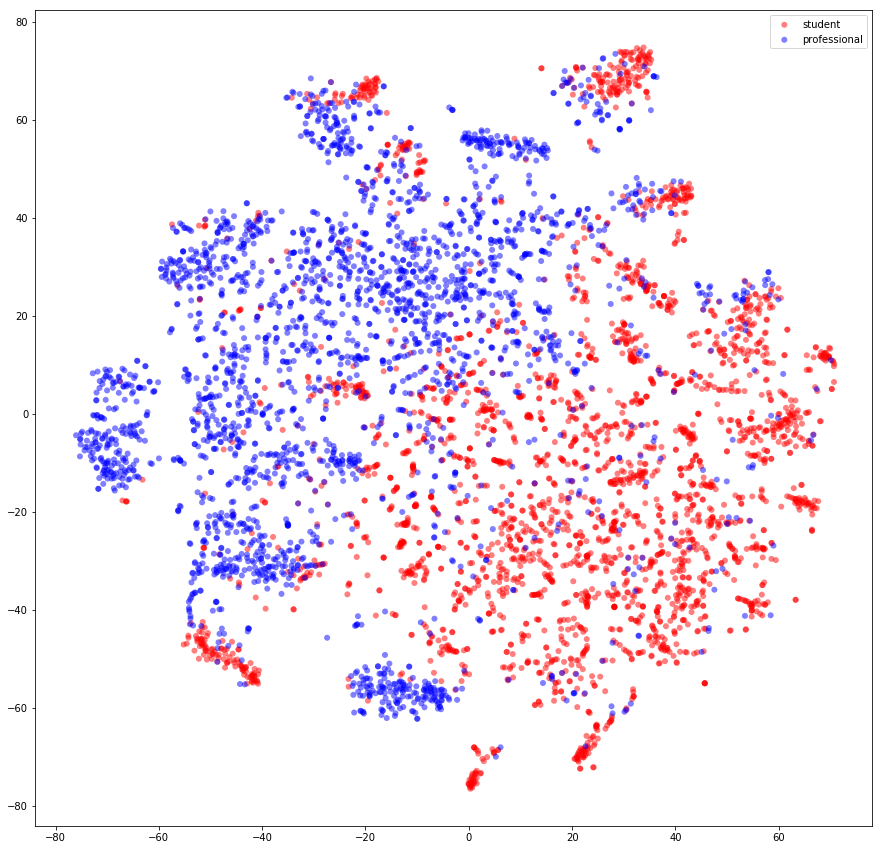

In [43]:
visu_embeddings(usr_tsne_emb, usr_tsne_lab)

# 6. Summary

The CareerVillage data contains several entities and different type of connections between them. My ultimate goal was to analyze this data only from the aspect of network structure.

I managed to separate the users into **students** and **professionals** using only the underlying knowledge graph. First I mapped the nodes of the network to the 10 dimensional Euclidean space with **node2vec**. Then I applied t-SNE dimensionality reduction to visualize the results.

**Feel free to reach out to [me](https://github.com/ferencberes) if you have any questions related to this topic or this notebook! :)**